In [1]:
%pip install --upgrade keras
import keras
print(keras.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
3.2.1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', readonly=True)

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/ml-project/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/sp-500-stocks

from zipfile import PyZipFile

zipfile = PyZipFile('sp-500-stocks.zip')
zipfile.extractall()

import pandas as pd

Mounted at /content/gdrive
kaggle.json
 94% 40.0M/42.4M [00:03<00:00, 22.3MB/s]
100% 42.4M/42.4M [00:03<00:00, 14.7MB/s]


In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold

In [4]:
df_stocks = pd.read_csv('sp500_stocks.csv')
sc = MinMaxScaler(feature_range = (0, 1))
scaler = sc.fit(df_stocks[["Close", "High", "Low", "Open", "Volume"]])
df_stocks[["Close", "High", "Low", "Open", "Volume"]] = scaler.transform(df_stocks[["Close", "High", "Low", "Open", "Volume"]])
print(df_stocks[["Close", "High", "Low", "Open", "Volume"]].shape)
df_stocks.drop(labels=['Adj Close'], axis='columns', inplace=True)
df_stocks.dropna(inplace=True)
df_stocks.set_index('Symbol', inplace=True)
grouped = df_stocks.groupby(level=0)
df_stocks_dict = {group: group_df for group, group_df in grouped}

(1806273, 5)


In [5]:
import numpy as np

numdays = 330
windowSize = 60
features = 5

sc = MinMaxScaler(feature_range = (0, 1))
megaDF = []
sizes = []
i = 0
for key in df_stocks_dict:
    temp_df = df_stocks_dict[key][(-1 * windowSize):].copy()  # Create a copy of the DataFrame
    temp_df.drop(columns=temp_df.columns[0], axis=1, inplace=True)

    if(i == 351) :
      print(temp_df)
    i += 1

    if temp_df.shape[0] == windowSize:  # Check if temp_df has the desired number of rows
        megaDF.append(temp_df.values)  # Append the values to megaDF
        sizes.append(windowSize)  # Update the sizes list
    else:
        print(f"Ignoring {key} due to insufficient data for window calculation")
        continue

mega_array = np.array(megaDF)
print(mega_array.shape)
# mode = max(set(sizes), key=sizes.count)
# print(mode)


Ignoring GEV due to insufficient data for window calculation
           Close      High       Low      Open    Volume
Symbol                                                  
O       0.007117  0.007087  0.007185  0.007154  0.003088
O       0.006977  0.007013  0.006989  0.007039  0.003540
O       0.006843  0.006900  0.006887  0.006973  0.003784
O       0.006892  0.006813  0.006840  0.006867  0.004899
O       0.006776  0.006901  0.006827  0.006907  0.024341
O       0.006827  0.006745  0.006837  0.006805  0.006457
O       0.006703  0.006839  0.006780  0.006910  0.004369
O       0.006756  0.006701  0.006772  0.006780  0.003693
O       0.006701  0.006692  0.006780  0.006778  0.003028
O       0.006694  0.006623  0.006706  0.006706  0.003365
O       0.006727  0.006702  0.006712  0.006671  0.004333
O       0.006629  0.006649  0.006675  0.006729  0.006552
O       0.006735  0.006643  0.006640  0.006643  0.003360
O       0.006604  0.006618  0.006615  0.006711  0.003976
O       0.006414  0.006443 

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(60, return_sequences=True, input_shape=[None, 5]),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(60, return_sequences=True),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(60, return_sequences=False),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **Below is cold that utlizes k-folds cross validation**

In [7]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for train_index, val_index in kf.split(mega_array):
    X_train, X_val = mega_array[train_index], mega_array[val_index]
    y_train, y_val = mega_array[train_index, 4], mega_array[val_index, 4]

    # Perform model training and evaluation using X_train, y_train, X_val, and y_val
for train_index, val_index in kf.split(mega_array):
    X_train, X_val = mega_array[train_index], mega_array[val_index]
    y_train, y_val = mega_array[train_index, 4], mega_array[val_index, 4]

    # Train your model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate your model
    loss = model.evaluate(X_val, y_val)
    print("Validation Loss:", loss)

model.save("UPDATE_lstm_model.h5")

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 9.1217e-04 - val_loss: 0.0020
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.3149e-04 - val_loss: 6.6679e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.3604e-04 - val_loss: 7.4908e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.5938e-04 - val_loss: 6.3710e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.4957e-04 - val_loss: 7.2171e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.1627e-04 - val_loss: 8.5588e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.9516e-04 - val_loss: 8.2270e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.3586e-04 - val_loss: 8.8719e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.8305e-04 - val_loss: 6.1475e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.1682e-04 - val_loss: 6.7256e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.0428e-04 

Validation Loss: 0.00039018067764118314


In [8]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True, title="series"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(windowSize, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(windowSize, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.title(title)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [9]:
def plot_learning_curves(loss, val_loss, title):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)

In [10]:
print("Evaluation: ")
model.evaluate(X_val, y_val)

Evaluation: 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6868e-04 


0.00039018067764118314

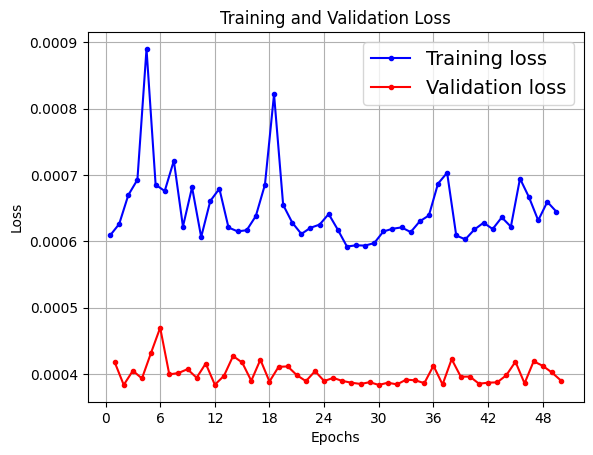

<Figure size 640x480 with 0 Axes>

In [11]:
plot_learning_curves(history.history["loss"], history.history["val_loss"],
                        "Training and Validation Loss")
plt.show()
plt.savefig('loss.png')


In [31]:
# prompt: using the stocks variable, grab stock data from a specific stock based on a variable. Then store the last x days of stock data where x is equal to the WindowSize variable

# Get the stock data for a specific stock
stock_name = "AAPL"  # Replace with the desired stock name
stock_data = df_stocks_dict[stock_name]

# Store the last WindowSize days of stock data
last_days_data = stock_data[-windowSize:].copy()

# Drop the 'Date' column
last_days_data.drop(columns=['Date'], inplace=True)

last_days_data = np.array(last_days_data)

reshaped_arr = last_days_data.reshape(1, windowSize, 5)
print(reshaped_arr.shape)
testPred = model.predict(reshaped_arr)

print(scaler.inverse_transform(reshaped_arr[0]))
print(testPred)
testPred = [testPred[0][0], 0,0,0,0]
testPred = np.array(testPred)
testPred = testPred.reshape(1, -1)

unscaledPred = scaler.inverse_transform(testPred)
print(unscaledPred[0])

(1, 60, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[1.83630005e+02 1.84259995e+02 1.80929993e+02 1.82160004e+02
  6.56030000e+07]
 [1.82679993e+02 1.82929993e+02 1.80300003e+02 1.81270004e+02
  4.73174000e+07]
 [1.88630005e+02 1.89139999e+02 1.85830002e+02 1.86089996e+02
  7.80058000e+07]
 [1.91559998e+02 1.91949997e+02 1.88820007e+02 1.89330002e+02
  6.87410000e+07]
 [1.93889999e+02 1.95330002e+02 1.92259995e+02 1.92300003e+02
  6.01339000e+07]
 [1.95179993e+02 1.95750000e+02 1.93830002e+02 1.95020004e+02
  4.23556000e+07]
 [1.94500000e+02 1.96380005e+02 1.94339996e+02 1.95419998e+02
  5.36313000e+07]
 [1.94169998e+02 1.96270004e+02 1.93110001e+02 1.95220001e+02
  5.48221000e+07]
 [1.92419998e+02 1.94759995e+02 1.91940002e+02 1.94270004e+02
  4.45940000e+07]
 [1.91729996e+02 1.92199997e+02 1.89580002e+02 1.92009995e+02
  4.71456000e+07]
 [1.88039993e+02 1.91800003e+02 1.87470001e+02 1.90940002e+02
  5.58594000e+07]
 [1.84399994e+02 1.87100006e+02 1.84350006e+02 1.87039993e+02
  5.54678

(100, 60, 5)
[0.00154212 0.00152119 0.00151448 0.00152891 0.02971375]
[0.00154212 0.00152119 0.00151448 0.00152891 0.02971375]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
[[0.00906666]]
[[1.34099998e+01 1.41450005e+01 1.33000002e+01 1.40100002e+01
  4.87109080e+07]]
[74.13322842  0.70999998  0.64999998  0.69999999  0.        ]


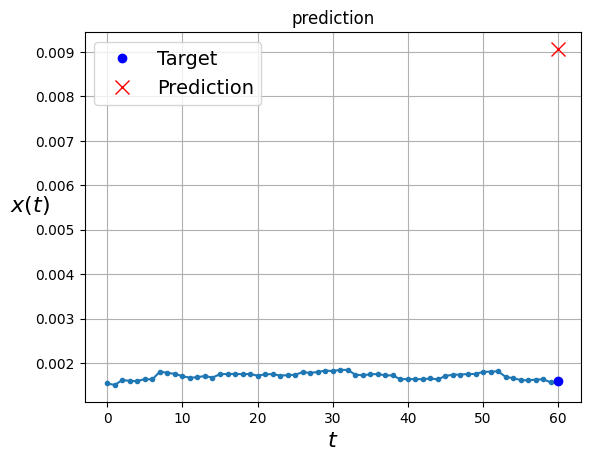

In [14]:
print(X_val.shape)
test = X_val[0]
reshaped_arr = test.reshape(1, windowSize, 5)

print(reshaped_arr[0][0])
print(test[0])

testPred = model.predict(reshaped_arr)
print(testPred)
testPred = [testPred[0][0], 0,0,0,0]
testPred = np.array(testPred)
testPred = testPred.reshape(1, -1)
reshaped_arr = reshaped_arr[0][-1].reshape(1, 5)
print(scaler.inverse_transform(reshaped_arr))
unscaledPred = scaler.inverse_transform(testPred)
print(unscaledPred[0])

plot_series(X_val[0, :, 0], y_val[0, 0], testPred[0, 0], title="prediction")